In [50]:
import time
start_time = time.time()

# Librerías

In [51]:
# Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score, 
    confusion_matrix, accuracy_score, precision_score, 
    recall_score, f1_score, roc_auc_score, 
    log_loss, roc_curve
)
from scipy.stats import bootstrap
from IPython.display import display, HTML

# Funciones auxiliares

In [52]:
# Funciones auxiliares

def preprocess_dataset(dataset, missing_threshold=0.3):
    """
    Limpia y preprocesa el dataset eliminando valores nulos y duplicados.
    Además, elimina columnas con un porcentaje alto de valores faltantes.

    Parámetros:
    - dataset (pd.DataFrame): Dataset a procesar.
    - missing_threshold (float): Porcentaje máximo de valores faltantes permitido (entre 0 y 1).

    Retorna:
    - dataset (pd.DataFrame): Dataset limpio.
    - duplicates_removed (int): Número de registros duplicados eliminados.
    - dropped_columns (list): Nombres de las columnas eliminadas por exceso de valores faltantes.
    """
    # Eliminar duplicados
    dataset_no_duplicates = dataset.drop_duplicates()
    duplicates_removed = len(dataset) - len(dataset_no_duplicates)

    # Identificar columnas con más del umbral de valores faltantes
    missing_percentage = dataset_no_duplicates.isnull().mean()
    columns_to_drop = missing_percentage[missing_percentage > missing_threshold].index.tolist()

    # Eliminar columnas con muchos valores faltantes
    dataset_cleaned = dataset_no_duplicates.drop(columns=columns_to_drop)

    return dataset_cleaned, duplicates_removed, columns_to_drop


def detect_variable_type(dataset, column):
    """
    Detecta automáticamente el tipo de una variable.
    
    Parameters:
    - dataset: pd.DataFrame, el dataset en el que se encuentra la columna.
    - column: str, nombre de la columna a analizar.
    
    Returns:
    - str, tipo de la variable ("Numérica", "Categórica Binaria", "Categórica No Binaria").
    """
    unique_values = dataset[column].nunique()
    
    if dataset[column].dtype == bool or unique_values == 2:
        return "Categórica Binaria"
    elif pd.api.types.is_numeric_dtype(dataset[column]):
        return "Numérica"
    else:
        return "Categórica No Binaria"
    

def convert_column_type(dataset: pd.DataFrame, column: str, new_type: str) -> None:
    """
    Convierte el tipo de una columna en un dataset según la selección del usuario.

    Parámetros:
    - dataset (pd.DataFrame): Dataset que contiene la columna a convertir.
    - column (str): Nombre de la columna a convertir.
    - new_type (str): Nuevo tipo de la variable ("Numérica", "Categórica Binaria", "Categórica No Binaria").

    Retorna:
    - None (la conversión se realiza directamente en el dataset).
    """
    try:
        if new_type == "Numérica":
            dataset[column] = pd.to_numeric(dataset[column], errors='coerce')
        
        elif new_type == "Categórica Binaria":
            dataset[column] = dataset[column].astype(str).astype("category")
        
        elif new_type == "Categórica No Binaria":
            dataset[column] = dataset[column].astype(str).astype("category")

    except Exception as e:
        print(f"❌ Error al convertir la columna '{column}' a {new_type}: {e}")


def aplicar_transformaciones(dataset: pd.DataFrame, variable_types: dict, 
                             variables_a_numerica: list, variables_a_categorica_binaria: list, 
                             variables_a_categorica_no_binaria: list):
    """
    Aplica transformaciones de tipos de datos a las columnas de un dataset.

    Parámetros:
    - dataset (pd.DataFrame): El dataset con las columnas a transformar.
    - variable_types (dict): Diccionario con los tipos de variables actuales.
    - variables_a_numerica (list): Lista de columnas a convertir a tipo "Numérica".
    - variables_a_categorica_binaria (list): Lista de columnas a convertir a "Categórica Binaria".
    - variables_a_categorica_no_binaria (list): Lista de columnas a convertir a "Categórica No Binaria".

    Retorna:
    - dataset (pd.DataFrame): Dataset con las transformaciones aplicadas.
    - variable_types (dict): Diccionario actualizado con los nuevos tipos de variables.
    """

    cambios_realizados = []

    # Aplicar transformaciones según las listas de columnas
    for col in variables_a_numerica:
        if col in dataset.columns:
            try:
                convert_column_type(dataset, col, "Numérica")
                variable_types[col] = "Numérica"
                cambios_realizados.append(f"{col} → Numérica")
            except Exception as e:
                print(f"Error al convertir '{col}' a Numérica: {e}")

    for col in variables_a_categorica_binaria:
        if col in dataset.columns:
            try:
                convert_column_type(dataset, col, "Categórica Binaria")
                variable_types[col] = "Categórica Binaria"
                cambios_realizados.append(f"{col} → Categórica Binaria")
            except Exception as e:
                print(f"Error al convertir '{col}' a Categórica Binaria: {e}")

    for col in variables_a_categorica_no_binaria:
        if col in dataset.columns:
            try:
                convert_column_type(dataset, col, "Categórica No Binaria")
                variable_types[col] = "Categórica No Binaria"
                cambios_realizados.append(f"{col} → Categórica No Binaria")
            except Exception as e:
                print(f"Error al convertir '{col}' a Categórica No Binaria: {e}")

    # Mostrar resumen de los cambios
    if cambios_realizados:
        print("\nTransformaciones realizadas:")
        for cambio in cambios_realizados:
            print(f" - {cambio}")
    else:
        print("\nNo se realizaron cambios en los tipos de datos.")

    # Mostrar el estado final de los tipos de variables
    print("\nTipos de Variables Finales:")
    for col, var_type in variable_types.items():
        print(f"  {col}: {var_type}")

    return dataset, variable_types


def remove_suffix(col_name: str) -> str:
    """
    Elimina el último sufijo separado por guion bajo (_) en un nombre de columna.

    Parámetros:
    - col_name (str): Nombre de la columna.

    Retorna:
    - str: Nombre de la columna sin el último sufijo.
    """
    return col_name.rsplit("_", 1)[0] if "_" in col_name else col_name


def update_predictor_lists(df, fixed_predictors, candidate_predictors):
    """
    Actualiza las listas de predictores fijos y candidatos según los nombres de las columnas en el DataFrame.

    Parámetros:
    - df (pd.DataFrame): DataFrame con las columnas a analizar.
    - fixed_predictors (list): Lista de prefijos para los predictores fijos.
    - candidate_predictors (list): Lista de prefijos para los predictores candidatos.

    Retorna:
    - tuple:
        - updated_fixed (list): Lista de predictores fijos encontrados en el DataFrame.
        - updated_candidates (list): Lista de predictores candidatos encontrados en el DataFrame.
    """
    # Filtrar columnas que inician con los prefijos dados
    updated_fixed = list(set(col for col in df.columns if any(col.startswith(prefix) for prefix in fixed_predictors)))
    updated_candidates = list(set(col for col in df.columns if any(col.startswith(prefix) for prefix in candidate_predictors)))

    return updated_fixed, updated_candidates


def seleccion_forward(df, variables_fijas, variables_candidatas, objetivo, tipo_modelo='lineal', 
                      missing_data_handling='1', max_predictors=10, nivel_confianza=0.95):
    """
    Realiza una selección de variables hacia adelante (Forward Selection) basada en criterios estadísticos.

    Parámetros:
    - df (pd.DataFrame): DataFrame con las variables predictoras y la variable objetivo.
    - variables_fijas (list): Lista de variables que siempre deben estar en el modelo.
    - variables_candidatas (list): Lista de variables candidatas para la selección.
    - objetivo (str): Nombre de la variable objetivo.
    - tipo_modelo (str, opcional): Tipo de modelo a ajustar ("lineal" para regresión OLS, "logistica" para regresión logística).
    - missing_data_handling (str, opcional): Manejo de valores faltantes ('1' para eliminar filas con nulos).
    - max_predictors (int, opcional): Número máximo de predictores a seleccionar.
    - nivel_confianza (float, opcional): Nivel de confianza para la selección de variables (0.95 por defecto).

    Retorna:
    - dict: Un diccionario con:
        - 'mejores_variables': (list) Lista de las mejores variables seleccionadas.
        - 'mejor_criterio': (float) Valor óptimo del criterio de selección (BIC o AUC-ROC).
        - 'df_filtrado': (pd.DataFrame) DataFrame con las variables seleccionadas y sin valores nulos.
    """
    variables_modelo = list(variables_fijas)
    candidatas_restantes = list(variables_candidatas)
    
    # Inicializar los valores óptimos según el tipo de modelo
    if tipo_modelo == 'lineal':
        mejor_criterio = float('inf')  # Para BIC, menor es mejor
    elif tipo_modelo == 'logistica':
        mejor_criterio = 0  # Para AUC-ROC, mayor es mejor
    else:
        raise ValueError("El tipo_modelo debe ser 'lineal' o 'logistica'.")

    while candidatas_restantes and len(variables_modelo) < max_predictors:
        mejor_variable = None
        criterio_actual = None

        for variable in candidatas_restantes:
            variables_prueba = variables_modelo + [variable]
            X = df[variables_prueba].copy()

            if missing_data_handling == '1':
                X.dropna(inplace=True)

            # Asegurar que y tenga el mismo índice que X después de dropna()
            y = df.loc[X.index, objetivo]

            try:
                X = sm.add_constant(X.astype(float))
                y = y.astype(float)

                if tipo_modelo == 'lineal':
                    modelo = sm.OLS(y, X).fit()
                    criterio_actual = modelo.bic  # Se usa BIC para selección
                    p_valores = modelo.pvalues  # Obtener p-valores de todas las variables

                elif tipo_modelo == 'logistica':
                    modelo = sm.Logit(y, X).fit(disp=0)
                    y_pred_prob = modelo.predict(X)
                    criterio_actual = roc_auc_score(y, y_pred_prob)  # Se usa AUC-ROC para selección
                    p_valores = modelo.pvalues  # Obtener p-valores de todas las variables
                
                # Verificar si alguna variable tiene p-valor > (1 - nivel_confianza)
                variables_no_significativas = [var for var, p in p_valores.items() if p > (1 - nivel_confianza)]
                if 'const' in variables_no_significativas:
                    variables_no_significativas.remove('const')

                # Solo considerar la variable si es significativa
                if not variables_no_significativas:
                    if (tipo_modelo == 'lineal' and criterio_actual < mejor_criterio) or \
                       (tipo_modelo == 'logistica' and criterio_actual > mejor_criterio):
                        mejor_criterio = criterio_actual
                        mejor_variable = variable

            except Exception as e:
                print(f"❌ Error al procesar la variable '{variable}': {e}")
                continue

        if mejor_variable:
            print(f"✅ Se agrega la variable: {mejor_variable}")
            variables_modelo.append(mejor_variable)
            candidatas_restantes.remove(mejor_variable)
        else:
            print("\n🚫 No se encontraron variables adicionales significativas. Se detiene la selección.")
            break

    # Filtrar el DataFrame con las mejores variables y eliminar valores nulos
    df_filtrado = df[variables_modelo + [objetivo]].dropna()
    
    print("\n🔍 Variables finales seleccionadas:")
    print(", ".join(variables_modelo))

    return {
        'mejores_variables': variables_modelo,
        'mejor_criterio': mejor_criterio,
        'df_filtrado': df_filtrado
    }


def filter_dataset(dataset: pd.DataFrame, variable_types: dict, filters: list) -> pd.DataFrame:
    """
    Aplica múltiples filtros a un dataset según las condiciones definidas.

    Parámetros:
    - dataset (pd.DataFrame): Dataset a filtrar.
    - variable_types (dict): Diccionario con los tipos de variables en el dataset.
    - filters (list): Lista de filtros en formato [(variable, tipo_filtro, valores)].

    Retorna:
    - pd.DataFrame: Dataset filtrado.
    """
    if not filters:
        print("⚠️ No se han aplicado filtros al dataset.")
        return dataset
    
    original_rows = dataset.shape[0]
    dataset_filtered = dataset.copy()

    for selected_var, filter_type, filter_values in filters:
        if selected_var not in dataset_filtered.columns:
            print(f"⚠️ Advertencia: Variable '{selected_var}' no encontrada en el dataset. Filtro omitido.")
            continue

        try:
            if filter_type == "Igual":
                dataset_filtered = dataset_filtered[dataset_filtered[selected_var] == filter_values]
            
            elif filter_type == "Mayor o igual":
                dataset_filtered = dataset_filtered[dataset_filtered[selected_var] >= filter_values]

            elif filter_type == "Menor o igual":
                dataset_filtered = dataset_filtered[dataset_filtered[selected_var] <= filter_values]

            elif filter_type == "Mayor":
                dataset_filtered = dataset_filtered[dataset_filtered[selected_var] > filter_values]

            elif filter_type == "Menor":
                dataset_filtered = dataset_filtered[dataset_filtered[selected_var] < filter_values]

            elif filter_type == "Entre":
                if isinstance(filter_values, (tuple, list)) and len(filter_values) == 2:
                    dataset_filtered = dataset_filtered[
                        (dataset_filtered[selected_var] >= filter_values[0]) & 
                        (dataset_filtered[selected_var] <= filter_values[1])
                    ]
                else:
                    print(f"⚠️ Advertencia: El filtro 'Entre' requiere una tupla o lista con exactamente 2 valores. Filtro omitido para '{selected_var}'.")

            elif filter_type == "Categorías":
                if isinstance(filter_values, (list, tuple)):
                    dataset_filtered = dataset_filtered[
                        dataset_filtered[selected_var].astype(str).str.strip().str.lower().isin(
                            [str(val).strip().lower() for val in filter_values]
                        )
                    ]
                else:
                    print(f"⚠️ Advertencia: El filtro 'Categorías' requiere una lista o tupla de valores. Filtro omitido para '{selected_var}'.")

            else:
                print(f"⚠️ Advertencia: Tipo de filtro '{filter_type}' no reconocido para '{selected_var}'. Filtro omitido.")

        except Exception as e:
            print(f"❌ Error al aplicar filtro '{filter_type}' en '{selected_var}': {e}")
            continue

    filtered_rows = dataset_filtered.shape[0]

    # Mostrar resumen de filtros aplicados
    print("\n✅ Filtros aplicados:")
    for selected_var, filter_type, filter_values in filters:
        print(f" - {selected_var} → {filter_type}: {filter_values}")

    print(f"\n📊 El dataset ha pasado de {original_rows} filas a {filtered_rows} filas después de aplicar los filtros.")

    return dataset_filtered


def compute_confidence_interval(metric_values: np.ndarray, confidence: float) -> tuple:
    """
    Calcula el intervalo de confianza para una métrica usando bootstrap.

    Parámetros:
    - metric_values (np.ndarray): Distribución bootstrap de la métrica.
    - confidence (float): Nivel de confianza (entre 0 y 1).

    Retorna:
    - tuple: (límite inferior, límite superior) del intervalo de confianza.
    """
    if not (0 < confidence < 1):
        raise ValueError("El nivel de confianza debe estar entre 0 y 1.")
    
    lower_percentile = ((1 - confidence) / 2) * 100
    upper_percentile = (1 - (1 - confidence) / 2) * 100
    
    ci_lower, ci_upper = np.percentile(metric_values, [lower_percentile, upper_percentile])
    
    return ci_lower, ci_upper


def bootstrap_metric(y_test, y_pred, y_pred_proba, metric_func, n_bootstrap=1000):
    """
    Calcula la distribución bootstrap de una métrica.

    Parámetros:
    - y_test (pd.Series | np.ndarray): Valores reales de la variable objetivo.
    - y_pred (pd.Series | np.ndarray): Predicciones del modelo.
    - y_pred_proba (pd.Series | np.ndarray | None): Probabilidades de predicción (para métricas que lo requieran).
    - metric_func (callable): Función de métrica a evaluar.
    - n_bootstrap (int, opcional): Número de muestras bootstrap (1000 por defecto).

    Retorna:
    - np.ndarray: Distribución bootstrap de la métrica.
    """
    rng = np.random.default_rng(42)  # Generador de números aleatorios reproducible
    metric_values = []

    y_test = np.array(y_test)
    y_pred = np.array(y_pred)
    y_pred_proba = np.array(y_pred_proba) if y_pred_proba is not None else None

    for _ in range(n_bootstrap):
        sample_idx = rng.choice(len(y_test), size=len(y_test), replace=True)
        sampled_y_test = y_test[sample_idx]
        sampled_y_pred = y_pred[sample_idx]

        if y_pred_proba is not None:
            sampled_y_pred_proba = y_pred_proba[sample_idx]
        else:
            sampled_y_pred_proba = None

        try:
            if sampled_y_pred_proba is not None and metric_func == roc_auc_score:
                metric_values.append(metric_func(sampled_y_test, sampled_y_pred_proba))
            else:
                metric_values.append(metric_func(sampled_y_test, sampled_y_pred))
        except Exception as e:
            warnings.warn(f"Error en una iteración de bootstrap: {e}")
            continue

    return np.array(metric_values)


def evaluate_model(y_test, y_pred, target_type, threshold=0.5, confidence=0.95, n_bootstrap=1000):
    """
    Evalúa un modelo de clasificación o regresión con métricas estándar e intervalos de confianza bootstrap.

    Parámetros:
    - y_test (pd.Series | np.ndarray): Valores reales de la variable objetivo.
    - y_pred (pd.Series | np.ndarray): Predicciones del modelo.
    - target_type (str): Tipo de variable objetivo ("Categórica Binaria" o "Numérica").
    - threshold (float, opcional): Umbral para convertir probabilidades en clases en clasificación (por defecto 0.5).
    - confidence (float, opcional): Nivel de confianza para los intervalos de confianza (por defecto 0.95).
    - n_bootstrap (int, opcional): Número de muestras bootstrap para estimar intervalos de confianza (por defecto 1000).

    Retorna:
    - dict: Resultados con métricas y sus intervalos de confianza.
    """
    y_test = np.array(y_test)
    y_pred = np.array(y_pred)
    n = len(y_test)  # Tamaño del conjunto de prueba

    if target_type == "Categórica Binaria":

        # Convertir probabilidades en clases
        y_pred_class = (y_pred >= threshold).astype(int)

        # Mostrar el threshold
        display_threshold_text(threshold)

        # Mostrar la matriz de confusión estilizada
        print("\n📊 Matriz de Confusión:")
        display_confusion_matrix(y_test, y_pred_class)

        # Calcular métricas
        accuracy = accuracy_score(y_test, y_pred_class)
        precision = precision_score(y_test, y_pred_class, zero_division=0)
        recall = recall_score(y_test, y_pred_class, zero_division=0)
        specificity = recall_score(y_test, y_pred_class, pos_label=0, zero_division=0)
        f1 = f1_score(y_test, y_pred_class, zero_division=0)
        auc = roc_auc_score(y_test, y_pred)
        logloss = log_loss(y_test, y_pred)

        # Bootstrap para intervalos de confianza
        metrics_dict = {
            "Accuracy": accuracy_score,
            "Precision": lambda yt, yp: precision_score(yt, yp, zero_division=0),
            "Recall": lambda yt, yp: recall_score(yt, yp, zero_division=0),
            "Specificity": lambda yt, yp: recall_score(yt, yp, pos_label=0, zero_division=0),
            "F1": lambda yt, yp: f1_score(yt, yp, zero_division=0),
            "AUC": roc_auc_score
        }

        confidence_intervals = {}
        for metric_name, metric_func in metrics_dict.items():
            try:
                metric_values = bootstrap_metric(y_test, y_pred_class, y_pred, metric_func, n_bootstrap)
                ci_lower, ci_upper = compute_confidence_interval(metric_values, confidence)
                confidence_intervals[metric_name] = (ci_lower, ci_upper)
            except Exception as e:
                warnings.warn(f"No se pudo calcular el intervalo de confianza para {metric_name}: {e}")
                confidence_intervals[metric_name] = (None, None)

        # Crear diccionario con resultados
        results_dict = {
            "n": n,
            "Accuracy": (accuracy, confidence_intervals["Accuracy"]),
            "Precision": (precision, confidence_intervals["Precision"]),
            "Recall": (recall, confidence_intervals["Recall"]),
            "Specificity": (specificity, confidence_intervals["Specificity"]),
            "F1": (f1, confidence_intervals["F1"]),
            "AUC": (auc, confidence_intervals["AUC"]),
            "LogLoss": logloss
        }

        # Mostrar la tabla estilizada con las métricas
        print("\n📈 Métricas del modelo:")
        display_metrics_table(results_dict)

        # Curva ROC
        fpr, tpr, _ = roc_curve(y_test, y_pred)
        plt.figure()
        plt.plot(fpr, tpr, color='#7030A0', label=f"AUC = {auc:.2f}")
        plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
        plt.title("Curva ROC")
        plt.xlabel("1 - Especificidad")
        plt.ylabel("Sensibilidad")
        plt.legend()
        plt.show()

        return results_dict

    elif target_type == "Numérica":
        print("\n📊 Evaluación del modelo de regresión:")

        # Calcular métricas
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        # Intervalos de confianza bootstrap
        metrics_dict = {"MSE": mean_squared_error, "MAE": mean_absolute_error, "R2": r2_score}
        confidence_intervals = {}

        for metric_name, metric_func in metrics_dict.items():
            metric_values = bootstrap_metric(y_test, y_pred, None, metric_func, n_bootstrap)
            ci_lower, ci_upper = compute_confidence_interval(metric_values, confidence)
            confidence_intervals[metric_name] = (ci_lower, ci_upper)

        # Crear diccionario con resultados
        results_dict = {
            "n": n,
            "MSE": (mse, confidence_intervals["MSE"]),
            "MAE": (mae, confidence_intervals["MAE"]),
            "R2": (r2, confidence_intervals["R2"])
        }

        # Mostrar la tabla estilizada con las métricas
        print("\n📈 Métricas del modelo:")
        display_metrics_table(results_dict)

        return results_dict

    else:
        raise ValueError("El parámetro 'target_type' debe ser 'Numérica' o 'Categórica Binaria'.")
    

def create_dict_variables(dataset: pd.DataFrame, variable_types: dict) -> dict:
    """
    Crea un diccionario con las variables categóricas y sus respectivas categorías únicas.

    Parámetros:
    - dataset (pd.DataFrame): Dataset original antes de One-Hot Encoding.
    - variable_types (dict): Diccionario con los tipos de variables.

    Retorna:
    - dict: Diccionario con variables categóricas y sus categorías únicas.
    """
    dict_variables = {}

    for var, var_type in variable_types.items():
        if var not in dataset.columns:
            print(f"⚠️ Advertencia: La variable '{var}' no está presente en el dataset. Se omitirá.")
            continue

        if var_type.startswith("Categórica"):  # Filtra solo las variables categóricas
            unique_values = dataset[var].dropna().astype(str).unique().tolist()
            dict_variables[var] = unique_values

    return dict_variables


def find_best_threshold(y_true, y_pred_probs):
    """
    Encuentra el mejor umbral para la clasificación basado en la métrica F1-score.

    Parámetros:
    - y_true (array-like): Valores reales (0 o 1).
    - y_pred_probs (array-like): Probabilidades de predicción.

    Retorna:
    - float: Mejor umbral encontrado.
    """
    if not np.all(np.isin(y_true, [0, 1])):
        raise ValueError("⚠️ Error: y_true debe contener solo valores 0 y 1.")

    if np.isnan(y_pred_probs).any():
        raise ValueError("⚠️ Error: y_pred_probs contiene valores NaN.")

    best_threshold = 0.5
    best_f1 = 0

    for threshold in np.linspace(0.1, 0.9, num=81):  # Mejora precisión y estabilidad numérica
        y_pred = (y_pred_probs >= threshold).astype(int)

        try:
            f1 = f1_score(y_true, y_pred, zero_division=0)
        except Exception as e:
            warnings.warn(f"⚠️ Advertencia: No se pudo calcular F1-score con threshold={threshold:.2f}: {e}")
            continue

        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    return best_threshold


def generate_subgroup_name(subgroup_filters):
    """
    Genera un nombre de subgrupo basado en los filtros aplicados.

    Parámetros:
    - subgroup_filters (list): Lista de tuplas con (variable, filter_type, values)

    Retorna:
    - str: Nombre del subgrupo formateado.
    """
    subgroup_parts = []

    for variable, filter_type, values in subgroup_filters:
        # Convertimos `values` a string, manejando correctamente listas, tuplas y otros tipos
        if isinstance(values, (list, tuple)):
            if filter_type == "Entre" and len(values) == 2:
                values_str = f"({values[0]}-{values[1]})"  # Formato para rango
            else:
                values_str = "_".join(map(str, values))  # Convierte listas y tuplas a string separado por "_"
        else:
            values_str = str(values)  # Convierte números o strings directamente

        # Determinar el formato según `filter_type`
        if filter_type == "Categorías":
            subgroup_parts.append(f"{variable}:{values_str}")  # Formato más legible
        elif filter_type == "Mayor o igual":
            subgroup_parts.append(f"{variable}≥{values_str}")
        elif filter_type == "Menor o igual":
            subgroup_parts.append(f"{variable}≤{values_str}")
        elif filter_type == "Mayor":
            subgroup_parts.append(f"{variable}>{values_str}")
        elif filter_type == "Menor":
            subgroup_parts.append(f"{variable}<{values_str}")
        elif filter_type == "Igual":
            subgroup_parts.append(f"{variable}={values_str}")
        elif filter_type == "Entre":
            subgroup_parts.append(f"{variable}{values_str}")

    # Unimos todas las partes con ` & ` en caso de múltiples condiciones
    return " & ".join(subgroup_parts)


def combine_results_for_forest_plot(model_results, subgroups_results):
    """
    Combina los resultados del modelo principal y los subgrupos en un solo diccionario
    para usarlos en el forest plot, incluyendo todas las métricas.

    Parámetros:
    - model_results (dict): Resultados del modelo principal.
    - subgroups_results (dict): Resultados de los subgrupos.

    Retorna:
    - dict: Diccionario combinado con los resultados.
    """
    return {"Modelo Principal": model_results, **subgroups_results}

def order_models(model_results, subgroups_results, metric_names, min_values, main_model):
    """
    Ordena los modelos de acuerdo a los criterios especificados.
    """
    combined_results = {main_model: model_results, **subgroups_results}
    highlighted_models = []
    remaining_models = []
    
    for model, results in subgroups_results.items():
        superior_metric = False
        inferior_metric = False
        outside_rejection = True
        
        for metric in metric_names:
            if metric not in results or metric not in model_results:
                continue
            
            model_value, (model_lower, model_upper) = results[metric]["value"], results[metric]["conf_int"]
            main_value, (main_lower, main_upper) = model_results[metric]["value"], model_results[metric]["conf_int"]
            rejection_zone = min_values.get(metric, 0) if min_values else 0
            
            # Condición de rendimiento superior
            if model_lower > main_upper:
                superior_metric = True
            
            # Condición de rendimiento inferior
            if model_upper < main_lower:
                inferior_metric = True
            
            # Verificar si el IC está completamente fuera de la zona de rechazo
            if model_lower < rejection_zone:
                outside_rejection = False
        
        # Clasificar modelos según las condiciones
        if superior_metric and not inferior_metric and outside_rejection:
            highlighted_models.append(model)
        else:
            remaining_models.append(model)
    
    # Orden final: Modelos destacados primero, luego el Modelo Principal, después los restantes
    ordered_models = highlighted_models + [main_model] + remaining_models
    return ordered_models

def forest_plot(model_results, subgroups_results, metric_names, target, 
                min_values=None, main_model='Modelo Principal', model_name="Comparación de Modelos"):
    """
    Genera múltiples Forest Plots ordenando modelos según rendimiento.
    """
    # Reemplazar 'Recall' por 'Sensibility' solo para la visualización
    metric_names_display = ['Sensibility' if metric == 'Recall' else metric for metric in metric_names]
    
    num_metrics = len(metric_names)
    ordered_models = order_models(model_results, subgroups_results, metric_names, min_values, main_model)
    
    fig, axes = plt.subplots(1, num_metrics, figsize=(num_metrics * 5, max(5, len(ordered_models) * 0.5 + 2)), sharey=True)
    if num_metrics == 1:
        axes = [axes]
    
    combined_results = {m: model_results if m == main_model else subgroups_results[m] for m in ordered_models}
    labels_with_n = [
        f"{m} (n={combined_results[m]['n']['value']})" if 'n' in combined_results[m] else m
        for m in ordered_models
    ]
    y_positions = np.arange(len(ordered_models))
    
    for ax, (metric_name, metric_display) in zip(axes, zip(metric_names, metric_names_display)):
        values = np.array([combined_results[m][metric_name]["value"] for m in ordered_models])
        conf_intervals = np.array([combined_results[m][metric_name]["conf_int"] for m in ordered_models])
        lower_bounds, upper_bounds = conf_intervals[:, 0], conf_intervals[:, 1]
        
        if min_values and metric_name in min_values:
            ax.axvspan(0, min_values[metric_name], color='#FF8787', alpha=0.3)
        
        ax.errorbar(values, y_positions, xerr=[values - lower_bounds, upper_bounds - values], 
                    fmt='o', color='#FFC000', ecolor='black', elinewidth=2, capsize=4)
        
        if main_model in combined_results and metric_name in combined_results[main_model]:
            main_lower, main_upper = combined_results[main_model][metric_name]["conf_int"]
            ax.axvline(x=main_lower, linestyle='--', color='#7030A0', linewidth=1)
            ax.axvline(x=main_upper, linestyle='--', color='#7030A0', linewidth=1)
        
        if min_values and metric_name in min_values:
            ax.axvline(x=min_values[metric_name], linestyle='-', color='#FF0000', linewidth=2)
        
        # Construir título con el valor mínimo si está disponible
        min_value_text = f" (Valor Mínimo: {min_values[metric_name]:.2f})" if min_values and metric_name in min_values else ""
        ax.set_title(f"{metric_display}{min_value_text}")
        
        ax.set_xlim(0, 1)
        ax.set_xlabel(metric_display)
        ax.grid(True, linestyle='--', alpha=0.5)
    
    axes[0].set_yticks(y_positions)
    axes[0].set_yticklabels([f"{m}" if m != main_model else f"{m}" for m in labels_with_n])
    for label, model in zip(axes[0].get_yticklabels(), ordered_models):
        if model == main_model:
            label.set_fontweight("bold")
    
    axes[0].invert_yaxis()
    
    fig.suptitle(f"{model_name} - Target: {target}", fontsize=14, fontweight='bold')
    fig.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    # Mostrar la leyenda
    display_forest_plot_legend()
    

def display_styled_table(variables_dict):
    """
    Función para mostrar un diccionario como una tabla estilizada en Jupyter Notebook.

    Parámetros:
    - variables_dict (dict): Diccionario donde las claves son los nombres de las variables
      y los valores son sus descripciones.

    Retorna:
    - None (Muestra la tabla directamente en Jupyter Notebook).
    """
    # Convertir el diccionario a un DataFrame
    df_variables = pd.DataFrame(list(variables_dict.items()), columns=["Variable", "Descripción"])

    # Aplicar estilo a la tabla con la columna "Descripción" centrada correctamente
    styled_table = df_variables.style.set_properties(**{
        'background-color': '#F4F4F4',
        'border': '1px solid black',
        'color': 'black',
    }).set_table_styles([
        {'selector': 'th', 'props': [('background-color', '#7030A0'), ('color', 'white'), ('font-weight', 'bold'), ('text-align', 'center')]},
        {'selector': 'td', 'props': [('padding', '5px'), ('text-align', 'center')]}  # Centrar todas las celdas de datos
    ])

    # Mostrar la tabla
    display(styled_table)


def display_confusion_matrix(y_true, y_pred_class):
    """
    Muestra la matriz de confusión en un formato estilizado en Jupyter Notebook.

    Parámetros:
    - y_true (array-like): Valores reales de la variable objetivo.
    - y_pred_class (array-like): Predicciones del modelo (clases).

    Retorna:
    - None (Muestra la tabla directamente en Jupyter Notebook).
    """
    # Calcular la matriz de confusión
    unique_labels = sorted(np.unique(np.concatenate((y_true, y_pred_class))))
    cm = confusion_matrix(y_true, y_pred_class, labels=unique_labels)

    # Convertir en DataFrame para visualización
    cm_df = pd.DataFrame(cm, 
                         columns=[f"Predicción {label}" for label in unique_labels], 
                         index=[f"Real {label}" for label in unique_labels])

    # Aplicar estilo a la tabla
    styled_cm = cm_df.style.set_properties(**{
        'background-color': '#F4F4F4',
        'border': '1px solid black',
        'color': 'black',
        'text-align': 'center'
    }).set_table_styles([
        {'selector': 'th', 'props': [('background-color', '#7030A0'), ('color', 'white'), ('font-weight', 'bold')]},
        {'selector': 'td', 'props': [('padding', '5px')]}
    ])

    # Mostrar la tabla
    display(styled_cm)


def display_metrics_table(metrics_dict):
    """
    Muestra las métricas del modelo en una tabla estilizada con columnas:
    'Métrica', 'Valor' y 'Intervalo de confianza', excluyendo 'n' y 'LogLoss'.

    Parámetros:
    - metrics_dict (dict): Diccionario con métricas y sus intervalos de confianza.

    Retorna:
    - None (Muestra la tabla directamente en Jupyter Notebook).
    """
    # Excluir 'n' y 'LogLoss' de la tabla
    metrics_data = []
    for metric, value in metrics_dict.items():
        if metric in ["n", "LogLoss"]:
            continue  # Saltar estas métricas

        if isinstance(value, tuple):  # Si tiene intervalo de confianza
            metric_value, conf_interval = value
            conf_interval_str = f"[{conf_interval[0]:.2f}, {conf_interval[1]:.2f}]" if conf_interval[0] is not None else "N/A"
        else:
            metric_value = value
            conf_interval_str = "N/A"

        metrics_data.append([metric, f"{metric_value:.2f}", conf_interval_str])

    # Crear DataFrame con las métricas
    df_metrics = pd.DataFrame(metrics_data, columns=["Métrica", "Valor", "Intervalo de confianza"])

    # Aplicar estilo a la tabla
    styled_metrics_table = df_metrics.style.set_properties(**{
        'background-color': '#F4F4F4',
        'border': '1px solid black',
        'color': 'black',
        'text-align': 'center'
    }).set_table_styles([
        {'selector': 'th', 'props': [('background-color', '#7030A0'), ('color', 'white'), ('font-weight', 'bold')]},
        {'selector': 'td', 'props': [('padding', '5px')]},
    ])

    # Mostrar la tabla
    display(styled_metrics_table)


def display_threshold_text(threshold):
    """
    Muestra el threshold usado en la evaluación con un estilo visual atractivo,
    resaltando 'Evaluación con Threshold' en morado y el valor en negro con fondo blanco.

    Parámetros:
    - threshold (float): Umbral usado para clasificación binaria.

    Retorna:
    - None (Muestra el texto directamente en Jupyter Notebook).
    """
    html_content = f"""
    <p style="font-size:16px; background-color:white; padding:8px; display:inline-block;">
        <span style="color:#7030A0; font-weight:bold;">🔹Threshold calculado =</span>
        <span style="color:black; font-weight:bold;"> {threshold:.2f}</span>
    </p>
    """
    display(HTML(html_content))


def display_forest_plot_legend():
    """
    Muestra una leyenda en formato HTML con fondo blanco y texto negro,
    explicando los elementos del gráfico de Forest Plot.
    """
    legend_text = """
    <div style="font-size:14px; line-height:1.6; background-color:white; color:black; padding:10px; border-radius:5px; border:1px solid #ccc;">
        <b>🔎 Leyenda del Forest Plot:</b><br>
        🔴 <b>Área roja:</b> Representa la <i>zona de rechazo</i>, donde los valores están por debajo del mínimo esperado.<br>
        <span style="color:#FF0000;"><b>─────</b></span> <b>Línea continua roja:</b> Valor mínimo esperado para cada métrica.<br>
        <span style="color:#7030A0;"><b>— — —</b></span> <b>Línea discontinua morada:</b> Intervalo de confianza del Modelo Principal.<br>
        🟡 <b>Puntos amarillos:</b> Representan la métrica estimada para cada modelo o subgrupo.
    </div>
    """
    display(HTML(legend_text))

# Funciones por Pasos

In [53]:
def step_1(file_path):
    """
    Paso 1: Carga y preprocesamiento del dataset.

    Parámetros:
    - file_path (str): Ruta del archivo CSV o Excel a cargar.

    Retorna:
    - dataset (pd.DataFrame): Dataset limpio y preprocesado.
    - variable_types (dict): Diccionario con los tipos de variables detectadas.
    """
    print("\n📌 Paso 1: Carga y Preprocesamiento del Dataset")

    # Determinar extensión del archivo
    file_extension = file_path.split(".")[-1]

    try:
        if file_extension == "csv":
            dataset = pd.read_csv(file_path)
        elif file_extension in ["xls", "xlsx"]:
            dataset = pd.read_excel(file_path)
        else:
            raise ValueError("⚠️ Error: Formato de archivo no compatible. Usa un archivo CSV o Excel.")
    except Exception as e:
        print(f"❌ Error al cargar el archivo: {e}")
        return None, None

    # Verificar si el dataset está vacío
    if dataset.empty:
        print("⚠️ El archivo cargado está vacío. Usa un archivo válido.")
        return None, None

    # Normalizar nombres de columnas (evitar espacios y caracteres problemáticos)
    dataset.columns = [col.replace(" ", "_").replace(".", "_") for col in dataset.columns]

    # Preprocesar el dataset (eliminar duplicados y columnas con valores nulos excesivos)
    dataset, duplicates_removed, dropped_columns = preprocess_dataset(dataset)

    # Detectar tipos de variables automáticamente
    variable_types = {col: detect_variable_type(dataset, col) for col in dataset.columns}

    # Convertir tipos de columnas usando convert_column_type()
    for col, var_type in variable_types.items():
        convert_column_type(dataset, col, var_type)

    # Mostrar resumen del preprocesamiento
    print(f"✅ Dataset cargado con éxito. Contiene {dataset.shape[0]} filas y {dataset.shape[1]} columnas después de limpieza.")
    print(f"🗑️ Se eliminaron {duplicates_removed} registros duplicados.")
    if dropped_columns:
        print(f"📉 Columnas eliminadas por valores faltantes (>30%): {', '.join(dropped_columns)}.")
    else:
        print("✅ No se eliminaron columnas por valores faltantes.")

    print("\n📊 Tipos de Variables Detectados:")
    for col, var_type in variable_types.items():
        print(f"  {col}: {var_type}")

    return dataset, variable_types


warnings.simplefilter(action='ignore', category=FutureWarning)

def step_2_and_3(dataset: pd.DataFrame, variable_types: dict, target: str, pos_label=None):
    """
    Aplica transformaciones de tipos de datos, verifica la variable objetivo y muestra su distribución.

    Parámetros:
    - dataset (pd.DataFrame): Dataset original.
    - variable_types (dict): Diccionario con los tipos de variables seleccionados.
    - target (str): Nombre de la variable objetivo.
    - pos_label (opcional, cualquier tipo): Etiqueta positiva para clasificación binaria.

    Retorna:
    - tuple: (dataset_cleaned, target, pos_label)
    """
    print("\n📌 Paso 2: Selección de la Variable Target")

    # Copiar dataset para no modificar el original
    dataset = dataset.copy()

    if target not in dataset.columns:
        print("❌ Error: La variable seleccionada no existe en el dataset.")
        return None, None, None

    # Reemplazar valores inválidos con NaN y eliminar registros con target vacío
    dataset.replace(['None', '', 'nan', 'Nan', 'NaN'], np.nan, inplace=True)
    missing_rows_before = len(dataset)
    dataset_cleaned = dataset.dropna(subset=[target])
    missing_rows_after = len(dataset_cleaned)
    rows_removed = missing_rows_before - missing_rows_after

    # Calcular porcentaje de registros eliminados
    percentage_removed = (rows_removed / missing_rows_before) * 100 if missing_rows_before > 0 else 0

    if rows_removed > 0:
        print(f"⚠️ Se eliminaron {rows_removed} registros ({percentage_removed:.2f}% del total) por valores faltantes en '{target}'.")
    else:
        print("✅ No se eliminaron registros por valores faltantes en la variable target.")

    # Obtener valores únicos de la variable objetivo
    unique_values = dataset_cleaned[target].dropna().unique()

    # Determinar `pos_label` para variables categóricas binarias
    if variable_types[target] == "Categórica Binaria":
        if pos_label in unique_values:
            print(f"✅ Se ha seleccionado '{pos_label}' como etiqueta positiva.")
        else:
            # Si el pos_label no está en los valores únicos, advertir y asignar el primer valor por defecto
            print(f"⚠️ Advertencia: El `pos_label` proporcionado ('{pos_label}') no está entre los valores únicos de '{target}'.")
            print(f"⚠️ Se seleccionará automáticamente '{unique_values[1]}' como etiqueta positiva por defecto.")
            pos_label = unique_values[1]  # Asignar el primer valor único como `pos_label`
        
            print(f"✅ Etiqueta positiva seleccionada: '{pos_label}'")
    
        # Asignar 1 a la `pos_label` y 0 a la otra categoría
        neg_label = [val for val in unique_values if val != pos_label][0] # Otra categoría
        dataset_cleaned[target] = dataset_cleaned[target].apply(lambda x: 1 if x == pos_label else 0)

        print(f"✅ Variable '{target}' transformada a (1: '{pos_label}', 0: '{neg_label}').")

    print("✅ Variable Target confirmada y registros con valores faltantes eliminados.")

    print("\n📌 Paso 3: Confirmación de Tipos de Variables y Distribución de la Variable Target")
    
    # Crear un DataFrame con la información de tipos de variables
    type_info = pd.DataFrame({
        "Variable": dataset_cleaned.columns,
        "Tipo seleccionado": [variable_types[col] for col in dataset_cleaned.columns]
    })
    
    print(type_info)

    # Visualizar distribución de la variable target
    if variable_types[target] == "Categórica Binaria":
        print(f"\n📊 Distribución de la Variable Target: {target}")
        target_counts = dataset_cleaned[target].value_counts()

        plt.figure(figsize=(6, 4))
        sns.barplot(x=target_counts.index.astype(str), y=target_counts.values, palette=['#7030A0', '#FFC000'])
        plt.xlabel("Categoría")
        plt.ylabel("Frecuencia")
        plt.title(f"Distribución de la Variable Target: {target}")
        plt.show()

    elif variable_types[target] == "Numérica":
        print(f"\n📊 Distribución de la Variable Target (Histograma): {target}")

        plt.figure(figsize=(6, 4))
        sns.histplot(dataset_cleaned[target], kde=True, bins=30, color='#7030A0')
        plt.xlabel(target)
        plt.ylabel("Frecuencia")
        plt.title(f"Distribución de la Variable Target: {target}")
        plt.show()

        print("\n📊 Boxplot de la Variable Target:")

        plt.figure(figsize=(6, 4))
        sns.boxplot(y=dataset_cleaned[target], palette=['#7030A0'])
        plt.ylabel(target)
        plt.title(f"Boxplot de la Variable Target: {target}")
        plt.show()

    return dataset_cleaned, target, pos_label


def step_4(target: str, variable_types: dict, selected_model: str = None, train_size: float = 0.8):
    """
    Paso 4: Selección del Modelo en Jupyter Notebook.

    Parámetros:
    - target (str): Variable objetivo del modelo.
    - variable_types (dict): Diccionario con los tipos de variables.
    - selected_model (str, opcional): Modelo seleccionado por el usuario.
    - train_size (float, opcional): Proporción del dataset usada para entrenamiento (0.05 a 0.95).

    Retorna:
    - tuple: (selected_model, train_size)
    """
    print("\n📌 Paso 4: Selección del Modelo")

    target_type = variable_types.get(target, "Numérica")

    # Definir modelos disponibles
    if target_type == "Numérica":
        models = [
            "Regresión Lineal",
            "Regresión No Lineal",
            "Árbol de Decisión",
            "Random Forest",
            "BaggingRegressor",
            "XGBoost",
            "Red Neuronal"
        ]
    else:  # Clasificación
        models = ["Regresión Logística"]

    # Validar modelo seleccionado
    if selected_model not in models:
        print(f"⚠️ Selección no válida o no proporcionada. Usando '{models[0]}' por defecto.")
        selected_model = models[0]

    # Validar tamaño del conjunto de entrenamiento
    if not (0.05 <= train_size <= 0.95):
        raise ValueError("❌ Error: 'train_size' debe estar entre 0.05 y 0.95. Intenta con un valor dentro de este rango.")

    print(f"✅ Modelo confirmado: {selected_model}")
    print(f"✅ Tamaño del conjunto de entrenamiento: {train_size:.2f}")

    return selected_model, train_size


def step_5(dataset: pd.DataFrame, target: str, fixed_predictors=None, 
           candidate_predictors=None, missing_data_handling='1'):
    """
    Paso 5: Selección de Variables Predictoras en Jupyter Notebook.

    Parámetros:
    - dataset (pd.DataFrame): El dataset procesado.
    - target (str): Nombre de la variable objetivo.
    - fixed_predictors (list, opcional): Lista de variables predictoras fijas seleccionadas.
    - candidate_predictors (list, opcional): Lista de variables predictoras candidatas seleccionadas.
    - missing_data_handling (str, opcional): Método de manejo de valores nulos:
        - "1" = Solo reportar cuántos valores nulos hay, pero NO eliminar.
        - "2" = Imputación futura (no implementada).

    Retorna:
    - tuple:
        - fixed_predictors (list): Variables predictoras fijas seleccionadas.
        - candidate_predictors (list): Variables predictoras candidatas seleccionadas.
        - dataset_cleaned (pd.DataFrame): Dataset con las variables seleccionadas (sin eliminación de filas).
        - missing_data_handling (str): Opción elegida para el manejo de valores faltantes.
    """
    print("\n📌 Paso 5: Selección de Variables Predictoras")

    # Copia del dataset para evitar modificar el original
    dataset_cleaned = dataset.copy()

    # Validar listas de predictores
    fixed_predictors = fixed_predictors or []
    candidate_predictors = candidate_predictors or []

    selected_predictors = fixed_predictors + candidate_predictors
    if not selected_predictors:
        print("❌ Error: Debes seleccionar al menos una variable predictora.")
        return None, None, None, None

    # Verificar que las variables seleccionadas existen en el dataset
    missing_columns = [col for col in selected_predictors if col not in dataset_cleaned.columns]
    if missing_columns:
        print(f"⚠️ Advertencia: Las siguientes variables no existen en el dataset y serán ignoradas: {', '.join(missing_columns)}")
        selected_predictors = [col for col in selected_predictors if col in dataset_cleaned.columns]

    # Reporte de valores nulos por variable seleccionada
    missing_counts = dataset_cleaned[selected_predictors].isnull().sum()
    rows_with_missing = dataset_cleaned[selected_predictors].isnull().any(axis=1).sum()

    print("\n📊 Cantidad de valores nulos por variable seleccionada:")
    print(missing_counts)

    # NO eliminar registros, solo informar
    if missing_data_handling == '1':
        print("\n🔹 Se eliminarán en pasos posteriores los registros con valores faltantes de los predictores que entren en el modelo.")
    elif missing_data_handling == '2':
        print("\n⚠️ La imputación de valores faltantes todavía no está disponible. Se mantendrán los valores nulos en el dataset.")
    else:
        print("\n⚠️ Opción de manejo de valores faltantes no válida. Se mantiene el dataset original.")

    print("\n✅ Variables predictoras seleccionadas correctamente.")
    print(f"📌 Máximo de 10 predictores serán usados en el modelo.")

    return fixed_predictors, candidate_predictors, dataset_cleaned, missing_data_handling


def step_6(dataset: pd.DataFrame, fixed_predictors: list, candidate_predictors: list, 
           target: str, variable_types: dict, train_size: float, missing_data_handling: str):
    """
    Paso 6: Entrenamiento del Modelo.

    Parámetros:
    - dataset (pd.DataFrame): Dataset procesado.
    - fixed_predictors (list): Lista de variables predictoras fijas seleccionadas.
    - candidate_predictors (list): Lista de variables predictoras candidatas seleccionadas.
    - target (str): Variable objetivo.
    - variable_types (dict): Diccionario con los tipos de variables.
    - train_size (float): Proporción del dataset usada para entrenamiento.
    - missing_data_handling (str): Método de manejo de valores nulos.

    Retorna:
    - model (sklearn Pipeline): Modelo entrenado.
    - test_dataset (pd.DataFrame): Dataset de prueba para evaluación.
    - target_type (str): Tipo de la variable objetivo.
    - selected_features (list): Lista de variables seleccionadas tras la selección de características.
    """
    print("\n📌 Paso 6: Entrenamiento del Modelo")

    test_size = 1 - train_size
    target_type = variable_types.get(target, "Numérica")

    # Validar que los predictores existen en el dataset
    selected_predictors = list(set(fixed_predictors + candidate_predictors))
    missing_cols = [col for col in selected_predictors if col not in dataset.columns]

    if missing_cols:
        print(f"⚠️ Advertencia: Las siguientes variables no están en el dataset y serán ignoradas: {missing_cols}")
        selected_predictors = [col for col in selected_predictors if col in dataset.columns]

    # Crear copia del dataset
    dataset_clean = dataset[selected_predictors + [target]].copy()

    # Aplicar One-Hot Encoding para variables categóricas
    dataset_clean = pd.get_dummies(dataset_clean, drop_first=True).apply(pd.to_numeric, errors='coerce')
    print(f"✅ Datos transformados con get_dummies(). Filas actuales: {dataset_clean.shape[0]}")

    # Obtener la nueva versión del target después de get_dummies()
    new_target_list, _ = update_predictor_lists(dataset_clean, [target], [])
    original_target = remove_suffix(new_target_list[0]) if target_type != 'Numérica' else new_target_list[0]
    dataset_clean = dataset_clean.rename(columns={new_target_list[0]: original_target})

    # Actualizar listas de predictores tras transformación
    new_fixed_predictors, new_candidate_predictors = update_predictor_lists(dataset_clean, fixed_predictors, candidate_predictors)

    # Determinar tipo de modelo (Regresión o Clasificación)
    modelo_tipo = 'lineal' if target_type == "Numérica" else 'logistica'

    # Aplicar selección forward
    resultado_seleccion = seleccion_forward(
        dataset_clean, new_fixed_predictors, new_candidate_predictors, target, tipo_modelo=modelo_tipo,
        missing_data_handling=missing_data_handling
    )

    df_filtrado = resultado_seleccion['df_filtrado']
    selected_features = resultado_seleccion['mejores_variables']

    print(f"✅ Variables seleccionadas ({len(selected_features)}): {selected_features}")
    print(f"✅ Filas después de la selección de variables: {df_filtrado.shape[0]}")

    # Preparar datos para entrenamiento
    X = df_filtrado[selected_features]
    y = df_filtrado[target]

    # División de datos en entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    print(f"✅ División de datos completada: {X_train.shape[0]} entrenamiento, {X_test.shape[0]} prueba.")

    # Asegurar que X_train y X_test mantengan la estructura del dataset original
    X_train1 = dataset_clean.loc[X_train.index]
    X_test1 = dataset_clean.loc[X_test.index]
    y_train1, y_test1 = y_train, y_test

    # Identificar características numéricas
    numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
    preprocessor = ColumnTransformer(
        transformers=[("num", StandardScaler(), numeric_features)], remainder="passthrough"
    )

    # Definir y entrenar el modelo
    if target_type == "Numérica":
        print(f"📊 Regresión Lineal: {round(train_size * 100)}% entrenamiento, {round(test_size * 100)}% prueba.")
        model = Pipeline([
            ("preprocessor", preprocessor),
            ("regressor", LinearRegression())
        ])
    else:
        print(f"📊 Regresión Logística: {round(train_size * 100)}% entrenamiento, {round(test_size * 100)}% prueba.")
        model = Pipeline([
            ("preprocessor", preprocessor),
            ("classifier", LogisticRegression(max_iter=1000))
        ])

    # Entrenar el modelo
    model.fit(X_train, y_train)
    print("✅ Modelo entrenado con éxito.")

    # Crear dataset de prueba con las variables originales
    test_dataset = X_test1.copy()
    test_dataset[target] = y_test1

    return model, test_dataset, target_type, selected_features


def step_7(model, test_dataset: pd.DataFrame, target: str, selected_features: list, 
           target_type: str, confidence: float, threshold: float = None, variables_dict: dict = None):
    """
    Paso 7: Evaluación del Modelo.

    Parámetros:
    - model (Pipeline): Modelo entrenado.
    - test_dataset (pd.DataFrame): Dataset de prueba.
    - target (str): Nombre de la variable objetivo.
    - selected_features (list): Variables predictoras utilizadas en el modelo.
    - target_type (str): Tipo de variable objetivo ("Numérica" o "Categórica Binaria").
    - confidence (float): Nivel de confianza para los intervalos de confianza.
    - threshold (float, opcional): Umbral para clasificación binaria. Si es None, se calcula automáticamente.
    - variables_dict (dict, opcional): Diccionario con descripciones de las variables para visualización.

    Retorna:
    - tuple:
        - model_results (dict): Diccionario con métricas y sus intervalos de confianza.
        - threshold (float): Umbral usado para clasificación binaria (None si es regresión).
    """
    print("\n📌 Paso 7: Evaluación del Modelo")

    # Mostrar tabla de variables si se proporciona el diccionario
    if variables_dict:
        print("\n📊 Información de Variables Utilizadas:")
        display_styled_table(variables_dict)

    # Seleccionar las variables predictoras en el dataset de prueba
    X_test = test_dataset[selected_features]
    y_test = test_dataset[target]

    # Predicción según el tipo de modelo
    if target_type == "Numérica":
        print("📊 Evaluación de Modelo de Regresión")
        y_pred = model.predict(X_test)
        y_pred_probs = None
    else:
        print("📊 Evaluación de Modelo de Clasificación")
        y_pred_probs = model.predict_proba(X_test)[:, 1]

        # Calcular el mejor threshold si no se proporciona
        if threshold is None:
            threshold = find_best_threshold(y_test, y_pred_probs)

    # Evaluar el modelo con las métricas correspondientes
    y_input = y_pred_probs if target_type != "Numérica" else y_pred
    metrics_full = evaluate_model(y_test, y_input, target_type=target_type, threshold=threshold, confidence=confidence)

    # Extraer el tamaño del dataset de prueba
    n = metrics_full["n"]

    # Formatear resultados para el forest plot
    model_results = {"n": {"value": n, "conf_int": None}}
    model_results.update({metric: {"value": value[0], "conf_int": value[1]} for metric, value in metrics_full.items() if isinstance(value, tuple)})

    print("✅ Evaluación completada.")
    return model_results, threshold


def step_8(test_dataset: pd.DataFrame, model, target: str, variable_types: dict, 
           filters: list, dict_variables: dict, confidence: float, threshold: float):
    """
    Filtra el dataset de prueba en subgrupos y evalúa el modelo en cada uno con un threshold ajustable.

    Parámetros:
    - test_dataset (pd.DataFrame): Dataset de prueba con las variables predictoras y target.
    - model: Modelo entrenado.
    - target (str): Nombre de la variable objetivo.
    - variable_types (dict): Diccionario con los tipos de variables.
    - filters (list of tuples): Lista de filtros en formato [(variable, tipo_filtro, valores)].
    - dict_variables (dict): Diccionario con variables categóricas y sus categorías antes de One-Hot Encoding.
    - confidence (float): Nivel de confianza para los intervalos de confianza.
    - threshold (float, opcional): Umbral para convertir probabilidades en clases.

    Retorna:
    - dict: Diccionario con las métricas de evaluación por cada subgrupo generado.
    """

    print("\n📌 Paso 8: Evaluación del Modelo en Subgrupos")

    # Ajustar filtros para variables categóricas transformadas
    adjusted_filters = []
    for var, filter_type, filter_values in filters:
        if var in dict_variables and filter_type == "Categorías":
            categories = dict_variables[var]
            if isinstance(filter_values, str):
                filter_values = [filter_values]

            transformed_filters = []
            available_vars = [f"{var}_{cat}" for cat in categories if f"{var}_{cat}" in test_dataset.columns]

            for value in filter_values:
                encoded_var = f"{var}_{value}"
                if encoded_var in test_dataset.columns:
                    transformed_filters.append((encoded_var, "Igual", True))
                else:
                    for alt_var in available_vars:
                        transformed_filters.append((alt_var, "Igual", False))

            adjusted_filters.extend(transformed_filters)
        else:
            adjusted_filters.append((var, filter_type, filter_values))

    # Filtrar el dataset según los filtros ajustados
    filtered_test_dataset = filter_dataset(test_dataset, variable_types, adjusted_filters)

    if filtered_test_dataset.shape[0] == 0:
        print("⚠️ El dataset filtrado está vacío. No se puede evaluar el modelo.")
        return {}

    # Separar variables predictoras y target
    X_test_filtered = filtered_test_dataset.drop(columns=[target])
    y_test_filtered = filtered_test_dataset[target]

    # Determinar el tipo de variable objetivo
    target_type = "Numérica" if variable_types[target] == "Numérica" else "Categórica Binaria"

    # Realizar predicciones según el tipo de variable
    if target_type == "Numérica":
        print("📊 Evaluación de Modelo de Regresión en Subgrupo")
        y_pred_filtered = model.predict(X_test_filtered)
    else:
        print("📊 Evaluación de Modelo de Clasificación en Subgrupo")
        y_pred_probs_filtered = model.predict_proba(X_test_filtered)[:, 1]

        # Evaluar usando probabilidades en clasificación
        y_pred_filtered = y_pred_probs_filtered

    # Evaluar el modelo con las métricas correspondientes
    metrics_filtered = evaluate_model(y_test_filtered, y_pred_filtered, target_type=target_type, threshold=threshold, confidence=confidence)

    # Obtener el tamaño del dataset
    n = metrics_filtered["n"]

    # Formatear resultados para el forest plot
    subgroups_results = {"n": {"value": n, "conf_int": None}}
    subgroups_results.update({metric: {"value": value[0], "conf_int": value[1]} for metric, value in metrics_filtered.items() if isinstance(value, tuple)})

    print("✅ Evaluación completada en el subgrupo.")
    return subgroups_results

# Paso 1: Subir archivo

Leemos el archivo y detectamos automáticamente el tipo de las variables

In [54]:
dataset, variable_types = step_1('titanic.csv')


📌 Paso 1: Carga y Preprocesamiento del Dataset
✅ Dataset cargado con éxito. Contiene 1309 filas y 11 columnas después de limpieza.
🗑️ Se eliminaron 0 registros duplicados.
📉 Columnas eliminadas por valores faltantes (>30%): Cabin.

📊 Tipos de Variables Detectados:
  PassengerId: Numérica
  Survived: Categórica Binaria
  Pclass: Numérica
  Name: Categórica No Binaria
  Sex: Categórica Binaria
  Age: Numérica
  SibSp: Numérica
  Parch: Numérica
  Ticket: Categórica No Binaria
  Fare: Numérica
  Embarked: Categórica No Binaria


In [55]:
# Creamos un glosario de las variables para posteriores visualizaciones
variables_dict = {
    "PassengerId": "Identificador único de cada pasajero",
    "Survived": "Indica si el pasajero sobrevivió (1) o no (0)",
    "Pclass": "Clase del ticket del pasajero (1ra, 2da o 3ra)",
    "Name": "Nombre completo del pasajero",
    "Sex": "Sexo del pasajero (male/female)",
    "Age": "Edad del pasajero en años",
    "SibSp": "Número de hermanos/esposos a bordo del Titanic",
    "Parch": "Número de padres/hijos a bordo del Titanic",
    "Ticket": "Número del ticket del pasajero",
    "Fare": "Tarifa pagada por el pasajero por su billete",
    "Embarked": "Puerto de embarque (C = Cherbourg, Q = Queenstown, S = Southampton)"
}

Si alguna de las variables se ha detectado incorrectamente, añadimos a la lista correspondiente la variable que queremos modificar

In [56]:
# Definir listas para almacenar las variables a transformar
variables_a_numerica = []
variables_a_categorica_binaria = []
variables_a_categorica_no_binaria = ['Pclass']

dataset, variable_types = aplicar_transformaciones(dataset, variable_types,
                                                   variables_a_numerica, variables_a_categorica_binaria, variables_a_categorica_no_binaria)


Transformaciones realizadas:
 - Pclass → Categórica No Binaria

Tipos de Variables Finales:
  PassengerId: Numérica
  Survived: Categórica Binaria
  Pclass: Categórica No Binaria
  Name: Categórica No Binaria
  Sex: Categórica Binaria
  Age: Numérica
  SibSp: Numérica
  Parch: Numérica
  Ticket: Categórica No Binaria
  Fare: Numérica
  Embarked: Categórica No Binaria


Creamos el diccionario de variables categóricas con sus respectivas categorías

In [57]:
dict_variables = create_dict_variables(dataset=dataset,
                                       variable_types=variable_types)

## Filtrar dataset

Ejemplos de Uso de `filter_dataset`

La función `filter_dataset` nos permite filtrar un dataset según las condiciones definidas en una lista de filtros. Cada filtro sigue el formato:

```python
filters = [(variable, tipo_filtro, valores)]
```

**Ejemplos**

1. Ejemplo con variable categórica (Queremos quedarnos con solamente los hombres)
```python
filters = [("Sex", "Categorías", ["male"])]
dataset_filtered = filter_dataset(dataset, variable_types, filters)
```

2. Ejemplo con variable numérica (Queremos obtener las personas mayores de 30)
```python
filters = [("Age", "Mayor o igual", 30)]
dataset_filtered = filter_dataset(dataset, variable_types, filters)
```

3. Ejemplo con dos variables (una categórica y una numérica) (Queremos obtener los hombres mayores de 30)
```python
filters = [("Sex", "Categorías", ["male"]), ("Age", "Mayor o igual", 30)]
dataset_filtered = filter_dataset(dataset, variable_types, filters)
```

4. Ejemplo con una variable categórica y varias categorías
```python
filters = [("Embarked", "Categorías", ["Q", "S"])]
dataset_filtered = filter_dataset(dataset, variable_types, filters)
```

5. Ejemplo con una variable categórica y varias categorías y una variable numérica
```python
filters = [("Embarked", "Categorías", ["Q", "S"]), ("Age", "Mayor o igual", 30)]
dataset_filtered = filter_dataset(dataset, variable_types, filters)
```

In [58]:
# Ejemplo con variable numérica (Queremos obtener las personas mayores de 30)
filters = []

dataset_filtered = filter_dataset(dataset, variable_types, filters)

⚠️ No se han aplicado filtros al dataset.


# Paso 2 y 3: Selección de la Variable Target y Distribución de la Variable

Selecciono la variable target y la etiqueta positiva en caso de que la variable target sea categórica


📌 Paso 2: Selección de la Variable Target
✅ No se eliminaron registros por valores faltantes en la variable target.
⚠️ Advertencia: El `pos_label` proporcionado ('1') no está entre los valores únicos de 'Survived'.
⚠️ Se seleccionará automáticamente '1' como etiqueta positiva por defecto.
✅ Etiqueta positiva seleccionada: '1'
✅ Variable 'Survived' transformada a (1: '1', 0: '0').
✅ Variable Target confirmada y registros con valores faltantes eliminados.

📌 Paso 3: Confirmación de Tipos de Variables y Distribución de la Variable Target
       Variable      Tipo seleccionado
0   PassengerId               Numérica
1      Survived     Categórica Binaria
2        Pclass  Categórica No Binaria
3          Name  Categórica No Binaria
4           Sex     Categórica Binaria
5           Age               Numérica
6         SibSp               Numérica
7         Parch               Numérica
8        Ticket  Categórica No Binaria
9          Fare               Numérica
10     Embarked  Categórica N

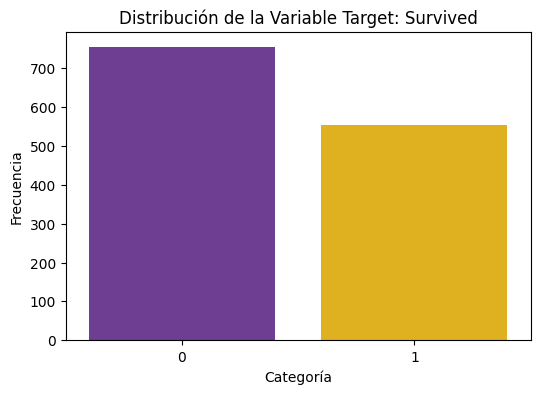

In [59]:
target = 'Survived'
pos_label = 1

dataset_cleaned, target, pos_label = step_2_and_3(dataset=dataset_filtered,
                                                  variable_types=variable_types,
                                                  target=target,
                                                  pos_label=pos_label)

# Paso 4: Selección del modelo y del tamaño del conjunto de entrenamiento

Seleccionar modelo y tamaño del conjunto de entrenamiento

In [60]:
selected_model = 'Regresión Logística'
train_size = 0.7

select_model, train_size = step_4(target=target,
                                  variable_types=variable_types,
                                  selected_model=selected_model,
                                  train_size=train_size)


📌 Paso 4: Selección del Modelo
✅ Modelo confirmado: Regresión Logística
✅ Tamaño del conjunto de entrenamiento: 0.70


# Paso 5: Selección de Variables Predictoras Fijas y Candidatas + Opción de Manejo de Valores Faltantes


    
    - Opción 1: Eliminar filas con valores faltantes. (missing_data_handling = '1')
    
    - Opción 2: Imputación de valores faltantes (missing_data_handling = '2') (función no disponible)

In [61]:
# Obtener todas las variables predictoras disponibles
available_predictors = [col for col in dataset_cleaned.columns if col != target]

print("Variables predictoras disponibles:")
print(available_predictors)

Variables predictoras disponibles:
['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Embarked']


Seleccionar las variables fijas y predictoras y seleccionar la opción de manejo de valores faltantes.

Marcar variables identificadoras.

In [62]:
fixed_predictors = []
candidate_predictors = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
identificadoras = ['PassengerId', 'Name', 'Ticket']
missing_data_handling = '1'

fixed, candidates, train_dataset, missing_data_handling = step_5(dataset=dataset_cleaned,
                                                  target=target,
                                                  fixed_predictors=fixed_predictors,
                                                  candidate_predictors=candidate_predictors,
                                                  missing_data_handling=missing_data_handling)


📌 Paso 5: Selección de Variables Predictoras

📊 Cantidad de valores nulos por variable seleccionada:
Pclass        0
Sex           0
Age         263
SibSp         0
Parch         0
Fare          1
Embarked      2
dtype: int64

🔹 Se eliminarán en pasos posteriores los registros con valores faltantes de los predictores que entren en el modelo.

✅ Variables predictoras seleccionadas correctamente.
📌 Máximo de 10 predictores serán usados en el modelo.


# Paso 6: Entrenamiento del modelo

Entrenamos el modelo

In [63]:
# Eliminación de variables identificadores manual
train_dataset.drop(columns=identificadoras, inplace=True)

In [64]:
trained_model, test_dataset, target_type, selected_features = step_6(train_dataset,
                                                             fixed,
                                                             candidates,
                                                             target, 
                                                             variable_types, 
                                                             train_size, 
                                                             missing_data_handling)


📌 Paso 6: Entrenamiento del Modelo
✅ Datos transformados con get_dummies(). Filas actuales: 1309
✅ Se agrega la variable: Sex_male
✅ Se agrega la variable: Fare
✅ Se agrega la variable: Age
✅ Se agrega la variable: Pclass_3
✅ Se agrega la variable: SibSp

🚫 No se encontraron variables adicionales significativas. Se detiene la selección.

🔍 Variables finales seleccionadas:
Sex_male, Fare, Age, Pclass_3, SibSp
✅ Variables seleccionadas (5): ['Sex_male', 'Fare', 'Age', 'Pclass_3', 'SibSp']
✅ Filas después de la selección de variables: 1045
✅ División de datos completada: 731 entrenamiento, 314 prueba.
📊 Regresión Logística: 70% entrenamiento, 30% prueba.
✅ Modelo entrenado con éxito.


# Paso 7: Evaluación del Modelo

- Seleccionamos el threshold:
    * **None**: Se selecciona el threshold mediante una función auxiliar la cual calculará el mejor umbral para maximizar el F1-Score.
    * ***Selección manual***: Fijamos un valor entre (0,1).

- Seleccionamos el nivel de restricción de los intervalos de confianza de las métricas de evaluación:
    * **0.99**: MUY restrictivo
    * **0.95**: Restrictivo
    * **0.90**: POCO restrictivo

In [65]:
threshold = None
confidence = 0.95

Evaluamos el modelo


📌 Paso 7: Evaluación del Modelo

📊 Información de Variables Utilizadas:


,Variable,Descripción
0,PassengerId,Identificador único de cada pasajero
1,Survived,Indica si el pasajero sobrevivió (1) o no (0)
2,Pclass,"Clase del ticket del pasajero (1ra, 2da o 3ra)"
3,Name,Nombre completo del pasajero
4,Sex,Sexo del pasajero (male/female)
5,Age,Edad del pasajero en años
6,SibSp,Número de hermanos/esposos a bordo del Titanic
7,Parch,Número de padres/hijos a bordo del Titanic
8,Ticket,Número del ticket del pasajero
9,Fare,Tarifa pagada por el pasajero por su billete


📊 Evaluación de Modelo de Clasificación



📊 Matriz de Confusión:


,Predicción 0,Predicción 1
Real 0,155,30
Real 1,48,81



📈 Métricas del modelo:


,Métrica,Valor,Intervalo de confianza
0,Accuracy,0.75,"[0.70, 0.80]"
1,Precision,0.73,"[0.64, 0.81]"
2,Recall,0.63,"[0.54, 0.71]"
3,Specificity,0.84,"[0.78, 0.89]"
4,F1,0.68,"[0.60, 0.74]"
5,AUC,0.77,"[0.72, 0.82]"


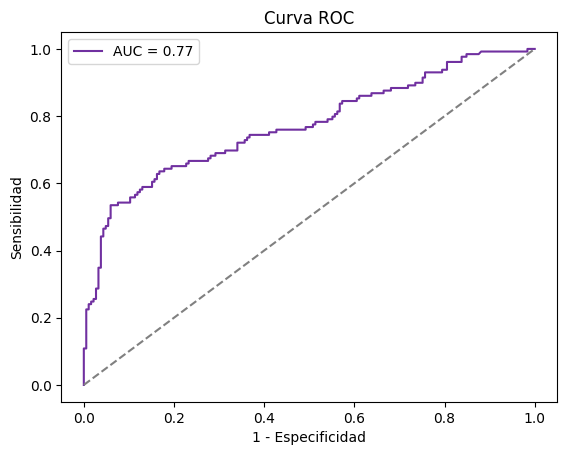

✅ Evaluación completada.


In [66]:
model_results, threshold_optimo = step_7(trained_model,
                      test_dataset,
                      target,
                      selected_features,
                      target_type,
                      confidence=confidence,
                      threshold=threshold,
                      variables_dict=variables_dict)

# Paso 8: Creación de Subgrupos

Creamos subgrupos si queremos estudiar una población más específica dentro de nuestro modelo. Estos subgrupos se crean utilizando la misma estructura que en `filter_dataset`.

```python
filters = [(variable, tipo_filtro, valores)]
```

**Ejemplos**

1. Ejemplo con variable categórica (Queremos quedarnos con solamente los hombres)
```python
filters = [("Sex", "Categorías", ["male"])]
dataset_filtered = filter_dataset(dataset, variable_types, filters)
```

2. Ejemplo con variable numérica (Queremos obtener las personas mayores de 30)
```python
filters = [("Age", "Mayor o igual", 30)]
dataset_filtered = filter_dataset(dataset, variable_types, filters)
```

3. Ejemplo con dos variables (una categórica y una numérica) (Queremos obtener los hombres mayores de 30)
```python
filters = [("Sex", "Categorías", ["male"]), ("Age", "Mayor o igual", 30)]
dataset_filtered = filter_dataset(dataset, variable_types, filters)
```

Creamos una lista con todos los subgrupos que queremos evaluar.

In [67]:
subgroup1 = [("Sex", "Categorías", "male")]
subgroup2 = [("Sex", "Categorías", 'female')]
subgroup3 = [('Age', 'Mayor o igual', 30)]
subgroup4 = [('Age', 'Mayor o igual', 30), ("Sex", "Categorías", "male")]
subgroup5 = [('Age', 'Mayor o igual', 30), ("Sex", "Categorías", "female")]

# subgroup1 = [('season', 'Categorías', '2012')]
# subgroup2 = [('season', 'Categorías', '2013')]
# subgroup3 = [('season', 'Categorías', '2014')]
# subgroup4 = [('season', 'Categorías', '2015')]
# subgroup5 = [('season', 'Categorías', '2016')]
# subgroup6 = [('season', 'Categorías', '2017')]
# subgroup7 = [('odd_h', 'Mayor', 3)]
# subgroup8 = [('odd_h', 'Menor', 2)]
# subgroup9 = [('odd_h', 'Entre', (2,3))]
# subgroup10 = [('season', 'Categorías', '2013'), ('odd_h', 'Entre', (2,3))]

list_of_subgroups = [subgroup1, subgroup2,
                     subgroup3, subgroup4,
                     subgroup5]

Evaluamos el modelo para cada uno de los subgrupos seleccionados


📌 Paso 8: Evaluación del Modelo en Subgrupos

✅ Filtros aplicados:
 - Sex_male → Igual: True

📊 El dataset ha pasado de 314 filas a 193 filas después de aplicar los filtros.
📊 Evaluación de Modelo de Clasificación en Subgrupo



📊 Matriz de Confusión:


,Predicción 0,Predicción 1
Real 0,142,3
Real 1,44,4



📈 Métricas del modelo:


,Métrica,Valor,Intervalo de confianza
0,Accuracy,0.76,"[0.69, 0.81]"
1,Precision,0.57,"[0.17, 1.00]"
2,Recall,0.08,"[0.02, 0.16]"
3,Specificity,0.98,"[0.95, 1.00]"
4,F1,0.15,"[0.03, 0.27]"
5,AUC,0.57,"[0.48, 0.66]"


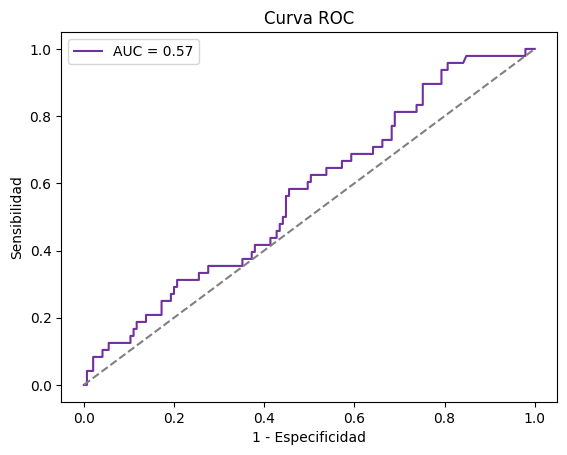

✅ Evaluación completada en el subgrupo.

📌 Paso 8: Evaluación del Modelo en Subgrupos

✅ Filtros aplicados:
 - Sex_male → Igual: False

📊 El dataset ha pasado de 314 filas a 121 filas después de aplicar los filtros.
📊 Evaluación de Modelo de Clasificación en Subgrupo



📊 Matriz de Confusión:


,Predicción 0,Predicción 1
Real 0,13,27
Real 1,4,77



📈 Métricas del modelo:


,Métrica,Valor,Intervalo de confianza
0,Accuracy,0.74,"[0.66, 0.82]"
1,Precision,0.74,"[0.66, 0.82]"
2,Recall,0.95,"[0.90, 0.99]"
3,Specificity,0.33,"[0.18, 0.46]"
4,F1,0.83,"[0.77, 0.88]"
5,AUC,0.81,"[0.73, 0.89]"


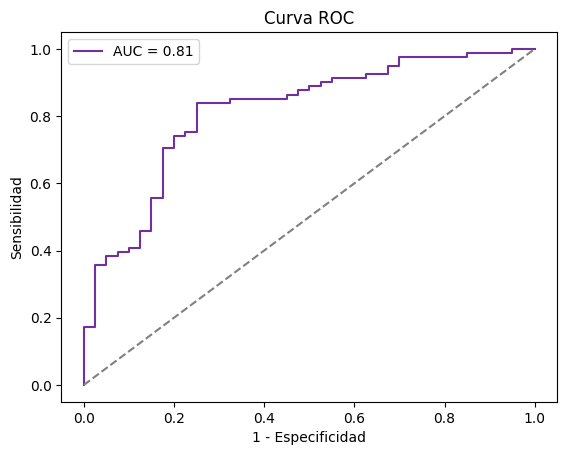

✅ Evaluación completada en el subgrupo.

📌 Paso 8: Evaluación del Modelo en Subgrupos

✅ Filtros aplicados:
 - Age → Mayor o igual: 30

📊 El dataset ha pasado de 314 filas a 138 filas después de aplicar los filtros.
📊 Evaluación de Modelo de Clasificación en Subgrupo



📊 Matriz de Confusión:


,Predicción 0,Predicción 1
Real 0,80,5
Real 1,18,35



📈 Métricas del modelo:


,Métrica,Valor,Intervalo de confianza
0,Accuracy,0.83,"[0.77, 0.89]"
1,Precision,0.88,"[0.76, 0.97]"
2,Recall,0.66,"[0.52, 0.78]"
3,Specificity,0.94,"[0.89, 0.99]"
4,F1,0.75,"[0.64, 0.84]"
5,AUC,0.84,"[0.76, 0.91]"


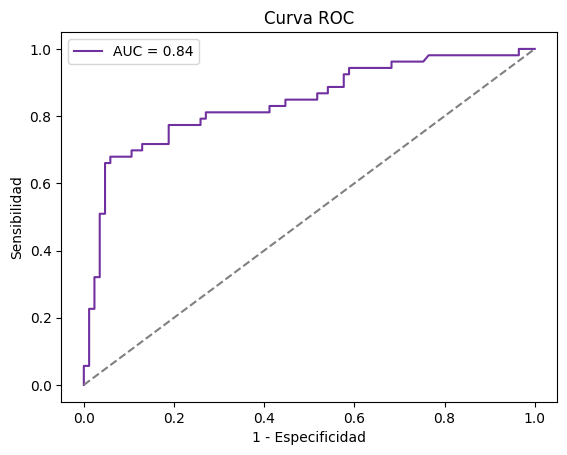

✅ Evaluación completada en el subgrupo.

📌 Paso 8: Evaluación del Modelo en Subgrupos

✅ Filtros aplicados:
 - Age → Mayor o igual: 30
 - Sex_male → Igual: True

📊 El dataset ha pasado de 314 filas a 85 filas después de aplicar los filtros.
📊 Evaluación de Modelo de Clasificación en Subgrupo



📊 Matriz de Confusión:


,Predicción 0,Predicción 1
Real 0,70,0
Real 1,15,0



📈 Métricas del modelo:


,Métrica,Valor,Intervalo de confianza
0,Accuracy,0.82,"[0.74, 0.91]"
1,Precision,0.00,"[0.00, 0.00]"
2,Recall,0.00,"[0.00, 0.00]"
3,Specificity,1.00,"[1.00, 1.00]"
4,F1,0.00,"[0.00, 0.00]"
5,AUC,0.63,"[0.46, 0.78]"


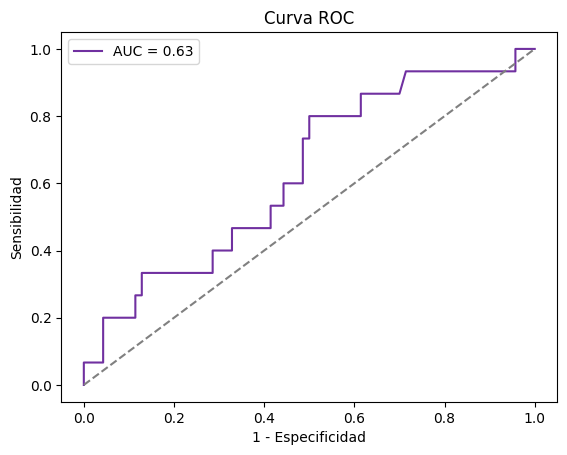

✅ Evaluación completada en el subgrupo.

📌 Paso 8: Evaluación del Modelo en Subgrupos

✅ Filtros aplicados:
 - Age → Mayor o igual: 30
 - Sex_male → Igual: False

📊 El dataset ha pasado de 314 filas a 53 filas después de aplicar los filtros.
📊 Evaluación de Modelo de Clasificación en Subgrupo



📊 Matriz de Confusión:


,Predicción 0,Predicción 1
Real 0,10,5
Real 1,3,35



📈 Métricas del modelo:


,Métrica,Valor,Intervalo de confianza
0,Accuracy,0.85,"[0.75, 0.94]"
1,Precision,0.88,"[0.77, 0.97]"
2,Recall,0.92,"[0.82, 1.00]"
3,Specificity,0.67,"[0.42, 0.90]"
4,F1,0.90,"[0.83, 0.96]"
5,AUC,0.81,"[0.64, 0.95]"


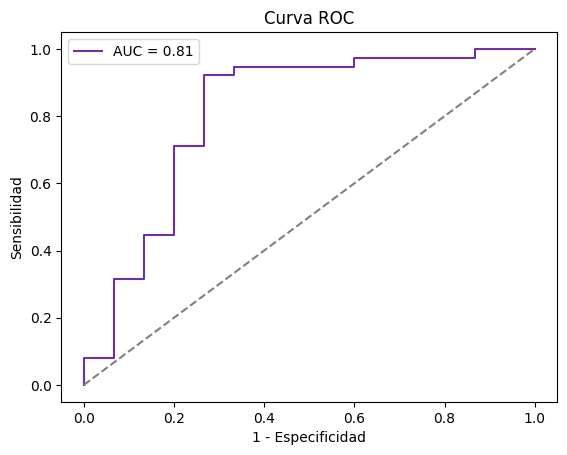

✅ Evaluación completada en el subgrupo.


In [68]:
subgroups_results = {}

for subgroup_filters in list_of_subgroups:
    subgroup_name = generate_subgroup_name(subgroup_filters)  # Generamos el nombre del subgrupo
    
    subgroups_results[subgroup_name] = step_8(
        test_dataset, trained_model, target, variable_types, subgroup_filters, dict_variables, confidence, threshold_optimo
    )

# Forest Plot Comparativa General y Subgrupos Generados

Selecciono la métrica que quiero comparar de entre las siguientes y el mínimo valor que debería tomar:

- Accuracy
- Precision
- Recall
- Specificity
- F1
- AUC

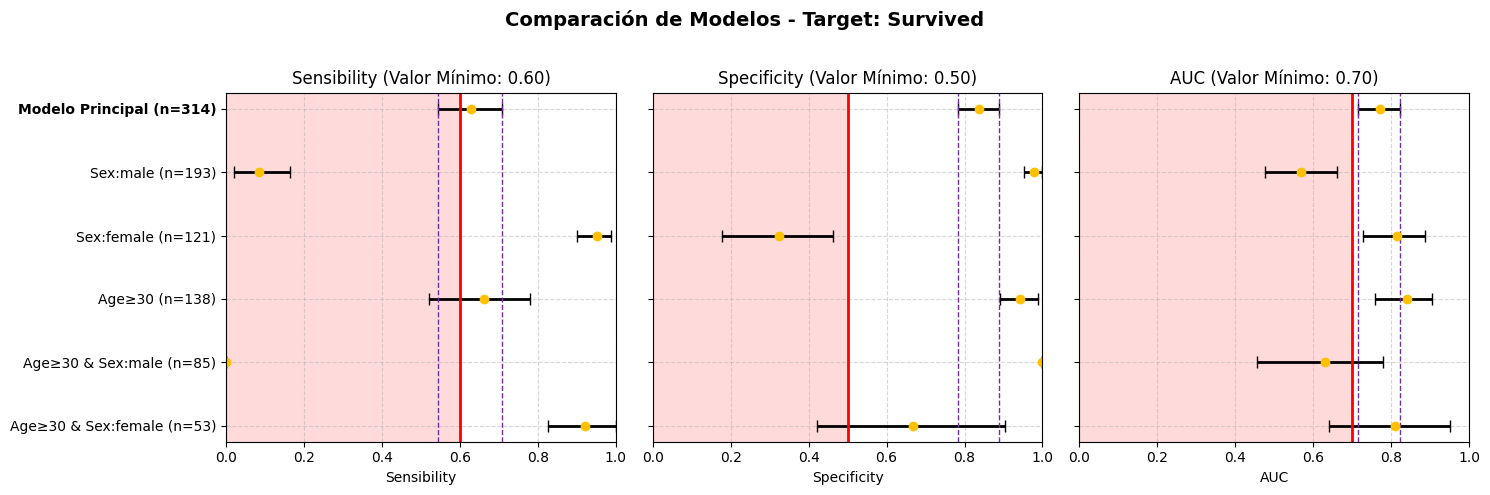

In [69]:
min_values = {"Recall": 0.6, "Specificity": 0.5, "AUC": 0.7}

forest_plot(
    model_results, 
    subgroups_results, 
    metric_names=["Recall", "Specificity", "AUC"],
    target=target,
    min_values=min_values,  # Agregar valores mínimos
    main_model="Modelo Principal",
    model_name="Comparación de Modelos"
)

In [70]:
end_time = time.time()
elapsed_time = end_time - start_time

minutes = int(elapsed_time // 60)
seconds = int(elapsed_time % 60)

print(f"Tiempo total de ejecución: {minutes} min {seconds} segs")

Tiempo total de ejecución: 0 min 25 segs
